In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mri_dataset import MRIDataset
from pytorch_resnet import PytorchResNet3D
from torch.utils.data import DataLoader
import torch

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

def display_image(img, phys_size, x=None, y=None, z=None, window=None, level=None, existing_ax=None):
    width, height, depth = phys_size
    
    size = np.flip(img.shape)
    spacing = phys_size / size

    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)

    if window is None:
        window = np.max(img) - np.min(img)

    if level is None:
        level = window / 2 + np.min(img)

    low,high = wl_to_lh(window,level)

    if existing_ax is None:
        # Display the orthogonal slices
        fig, axes = plt.subplots(1, 3, figsize=(14, 8))
    else:
        axes = existing_ax

    axes[0].imshow(img[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    axes[1].imshow(img[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    axes[2].imshow(img[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    axes[0].axhline(y * spacing[1], lw=1)
    axes[0].axvline(x * spacing[0], lw=1)

    axes[1].axhline(z * spacing[2], lw=1)
    axes[1].axvline(x * spacing[0], lw=1)

    axes[2].axhline(z * spacing[2], lw=1)
    axes[2].axvline(y * spacing[1], lw=1)

    if existing_ax is None:
        plt.show()

def display_patient_torch(d_set, i, box_size):
    sample = d_set[i][0]
    display_image(sample[0].numpy(), box_size)
    display_image(sample[1].numpy(), box_size)
    display_image(sample[2].numpy(), box_size)

In [2]:

localised_box_size = np.array([80, 80, 112])
generalised_box_size = np.array([0.289, 0.307483, 0.4804149]) * 200

base = '/vol/bitbucket/mb4617'
data_path = f'{base}/MRI_Crohns/numpy_datasets'
models_path = f'{base}/CrohnsDisease/trained_models'
suffix = 'all_data'
input_size = [87, 87, 87]

all_modalities = True
localisation = False
attention = True
fold = 0

input_features = [1, 1, 1] if all_modalities else [1, 0, 0]
folder = 'ti_imb' if localisation else 'ti_imb_generic'

dataset_path = f'{data_path}/{folder}/{suffix}_test_fold{fold}.npz'
curr_model_path = f'{models_path}/original_dataset_mode{int(all_modalities)}loc{int(localisation)}att{int(attention)}/fold{fold}'

dataset = MRIDataset(dataset_path, False, input_size, input_features, preprocess=True)

model = PytorchResNet3D(input_size, attention, 0.5, sum(input_features))

model.load_state_dict(torch.load(f'{models_path}/best_model/fold{fold}'))
model.eval()

['axial_t2', 'coronal_t2', 'axial_pc']


PytorchResNet3D(
  (conv1): Sequential(
    (0): ResidualBlock3D(
      (convs): Sequential(
        (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (shortcut): Conv3d(3, 64, kernel_size=(1, 1, 1), stride=(2, 2, 2), bias=False)
      (final): Sequential(
        (0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
      )
    )
    (1): ResidualBlock3D(
      (convs): Sequential(
        (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(64, 64, kernel_size=(3, 3,

In [3]:
device = torch.device('cuda')
model.to(device=device)
print('Device: ', device)

loader = DataLoader(dataset, len(dataset), False)

correct = 0
for x, y in loader:
    
    x = x.to(device=device)
    binary_y = torch.where(y == 0, 0, 1).to(device=device)
    print('labels: ', binary_y)

    with torch.no_grad():
        out = model(x)
    
    preds = out.argmax(dim=1).float()
    print('predictions: ', preds)
    print('accuracy: ', (preds == binary_y).float().mean())

Device:  cuda
labels:  tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
predictions:  tensor([1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
accuracy:  tensor(0.6512, device='cuda:0')


In [ ]:
correct_predictions = preds == binary_y


for i in range(len(dataset)):
    if correct_predictions[i]:
        continue
    
    print('Index: ', i)
    print('Label: ', binary_y[i])
    print('Pred:  ', preds[i])
    display_patient_torch(dataset, i, localised_box_size)

In [5]:
from sklearn.metrics import confusion_matrix, f1_score

improve = torch.Tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
           0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
           1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
           0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
           0., 0., 0.])

print(confusion_matrix(binary_y.cpu(), preds.cpu()))
print(f1_score(binary_y.cpu(), preds.cpu(), zero_division=0, average='weighted'))
print(f1_score(binary_y.cpu(), improve, zero_division=0, average='weighted'))

[[17  8]
 [ 7 11]]
0.65231724367937
0.5132441411511178


In [12]:
from mri_dataset import _random_rotate, _random_crop_gen
import torchvision.transforms as T
from scipy.ndimage import rotate

def _random_rotate_test(x):
    angle = np.random.normal(loc=0, scale=4)
    rotated_np = rotate(x, angle, axes=(2, 3), reshape=False, order=1, mode='nearest')
    return torch.from_numpy(rotated_np)

standard_dataset = MRIDataset(dataset_path, True, input_size, input_features, fast_rotate=False)
dataset_rot = MRIDataset(dataset_path, False, input_size, input_features, transforms=T.Lambda(_random_rotate_test))


['axial_t2', 'coronal_t2', 'axial_pc']
['axial_t2', 'coronal_t2', 'axial_pc']


In [10]:
from time import time
import cProfile

# Full augmentation ~ 37

## ~2s for nearest padding instead of constant

## Singel worker
## 5 - 35s
## 3 - 18s
## 2 - 15s
## 1 - 8.269

with cProfile.Profile() as pr:
    
    rotated_images = [standard_dataset[0][0][0] for _ in range(48)]

pr.print_stats()
# for i in range(1, 5):
#     display_image(rotated_images[i].numpy(), localised_box_size)
#     print(np.allclose(rotated_images[0].numpy(), rotated_images[i].numpy()))
    

         7689 function calls (7685 primitive calls) in 3.813 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    3.813    3.813 <ipython-input-10-ebe9a704d62b>:16(<listcomp>)
       48    0.000    0.000    0.000    0.000 _jit_internal.py:833(is_scripting)
      3/1    0.000    0.000    0.000    0.000 abc.py:100(__subclasscheck__)
       48    0.000    0.000    0.000    0.000 abc.py:96(__instancecheck__)
        1    0.000    0.000    0.000    0.000 cProfile.py:133(__exit__)
       48    0.001    0.000    0.001    0.000 dataset.py:170(__getitem__)
      144    0.000    0.000    0.000    0.000 dataset.py:171(<genexpr>)
       48    0.000    0.000    0.000    0.000 enum.py:664(value)
       48    0.000    0.000    0.681    0.014 functional.py:3691(grid_sample)
       48    0.000    0.000    0.168    0.003 functional.py:386(pad)
       48    0.001    0.000    0.166    0.003 functional.py:3936(_pad)
  

In [13]:

# Multimodal tests, different number of workers

## not given - 34.026
## 1 - 36.214s
## 2 - 36.395
## 4 - 36.405
## 6 - 37.477
## 8 - 37.023

## full model tests, 4 workers
# norm 36.66/38.22
# fast  7.48/ 9.03

worker_loader = DataLoader(standard_dataset, len(standard_dataset), False, num_workers=4)

start_t = time()
# with cProfile.Profile() as pr:
    
for x, y in worker_loader:
    x = x.to(device=device)
    binary_y = torch.where(y == 0, 0, 1).to(device=device)

    print(time() - start_t)
    with torch.no_grad():
        out = model(x)
    preds = out.argmax(dim=1).float()

    print((preds == binary_y).float().mean())

# pr.print_stats()
print(time() - start_t)


36.669445276260376
tensor(0.6512, device='cuda:0')
38.227866888046265


In [ ]:
with cProfile.Profile() as pr:
    
    rotated_images = [standard_dataset[0][0][0] for _ in range(48)]

pr.print_stats()

In [21]:
interp = T.InterpolationMode.BILINEAR

dataset_rot_2 = MRIDataset(dataset_path, False, input_size, input_features, transforms=T.RandomRotation(8, interpolation=interp))


['axial_t2', 'coronal_t2', 'axial_pc']


In [ ]:

with cProfile.Profile() as pr:
    
    rotated_images = [dataset_rot_2[0][0][0] for _ in range(48)]
    
pr.print_stats()
# for i in range(1, 5):
#     display_image(rotated_images[i].numpy(), localised_box_size)
#     print(np.allclose(rotated_images[0].numpy(), rotated_images[i].numpy()))

['axial_t2', 'coronal_t2', 'axial_pc']
         5007 function calls in 0.686 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       48    0.003    0.000    0.682    0.014 <ipython-input-22-201764741b96>:12(_rotate_by)
        1    0.001    0.001    0.686    0.686 <ipython-input-22-201764741b96>:32(<listcomp>)
       48    0.000    0.000    0.684    0.014 <ipython-input-22-201764741b96>:8(__call__)
       48    0.000    0.000    0.000    0.000 _jit_internal.py:833(is_scripting)
       48    0.000    0.000    0.000    0.000 abc.py:96(__instancecheck__)
        1    0.000    0.000    0.000    0.000 cProfile.py:133(__exit__)
       12    0.000    0.000    0.000    0.000 cycler.py:227(<genexpr>)
       48    0.000    0.000    0.001    0.000 dataset.py:170(__getitem__)
      144    0.000    0.000    0.000    0.000 dataset.py:171(<genexpr>)
       48    0.000    0.000    0.000    0.000 enum.py:664(value)
       48    0.000    0.00

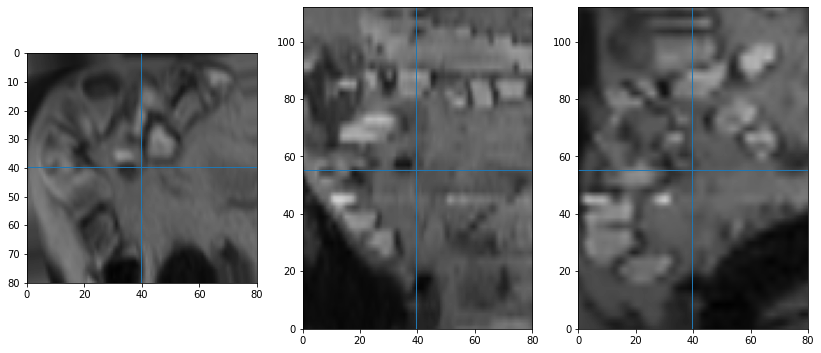

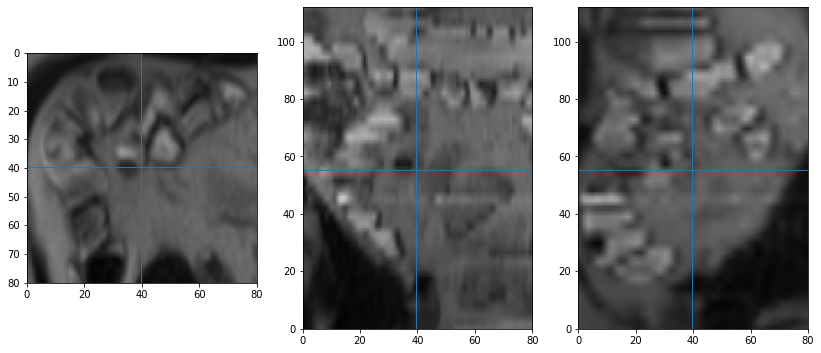

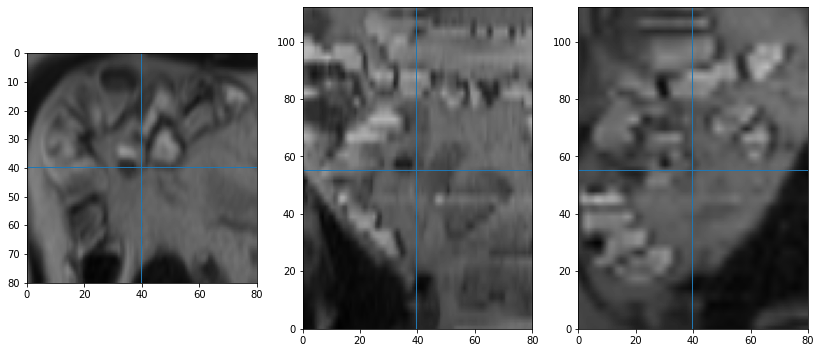

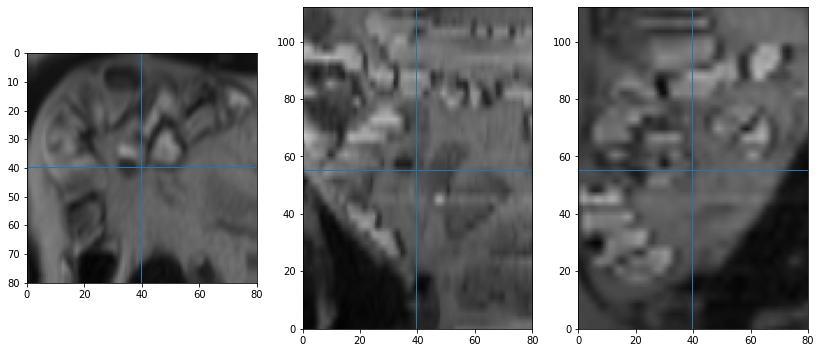

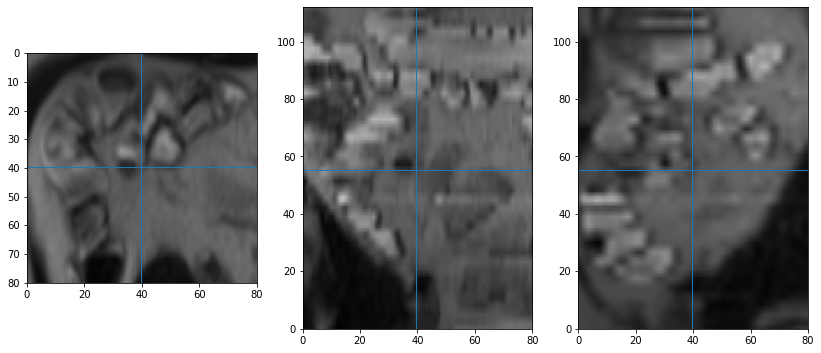

In [22]:

# 0.9s for batch of 48
class MyRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, std):
        self.std = std

    def __call__(self, x):
        angle = np.random.normal(loc=0, scale=self.std)
        return self._rotate_by(x, angle)
    
    def _rotate_by(self, x, angle):
        
        _, _, height, width = x.shape
        corner_angle = np.arctan(height / width)
        rad_angle = np.radians(np.abs(angle))
        
        distance_to_top_corner = np.hypot(height, width) * 0.5 * np.sin(corner_angle + rad_angle)
        pad_amount = int(np.ceil(distance_to_top_corner - height // 2))
        
        x = T.functional.pad(x, pad_amount, padding_mode='edge')
        
        x = T.functional.rotate(x, angle, interpolation=interp)
        return T.functional.center_crop(x, (height, width))
        
    
dataset_rot_3 = MRIDataset(dataset_path, False, input_size, input_features, transforms=MyRotationTransform(4.0))


with cProfile.Profile() as pr:
    
    rotated_images = [dataset_rot_3[0][0][0] for _ in range(48)]
    
pr.print_stats()


for i in range(0, 5):
    display_image(rotated_images[i].numpy(), localised_box_size)

In [ ]:
def _random_rotate_test2(x, angle):
    rotated_np = rotate(x, angle, axes=(2, 3), reshape=False, order=5, mode='nearest')
    return torch.from_numpy(rotated_np)

test_sample = dataset.data[0][0]
print(test_sample.shape)

for ang in range(-8, 9, 2):
    print(ang)
    display_image(_random_rotate_test2(test_sample, ang)[0].numpy(), generalised_box_size)
    display_image(MyRotationTransform(1)._rotate_by(test_sample, ang)[0].numpy(), generalised_box_size)

In [28]:
import matplotlib.pyplot as plt

torch.Size([43, 3, 99, 99, 99])
158.00267 ,  103.54464
0.0 - 1702.0


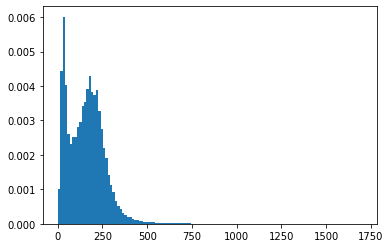

143.29655 ,  89.861824
0.0 - 1181.0


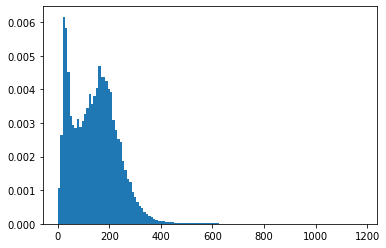

119.16877 ,  72.88987
0.0 - 748.0


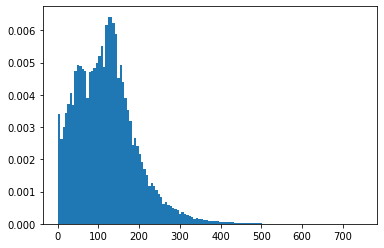

In [34]:
def show_dist(dset):
    for chan in range(3):
        curr_chan_data = dset[:,chan].numpy().flatten()
        print(np.mean(curr_chan_data),', ',np.std(curr_chan_data))
        print(np.min(curr_chan_data), '-', np.max(curr_chan_data))
        plt.hist(curr_chan_data, bins=128, density=True)
        plt.show()
        
image_data = torch.stack([d for d,_ in dataset_rot_3.data], axis=0)
print(image_data.shape)
show_dist(image_data)


158.00253 ,  103.665504
-24.226744 - 1708.1682


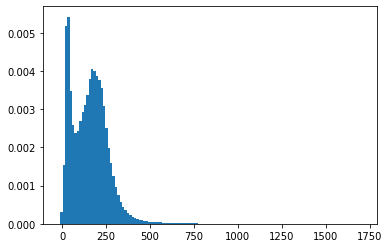

143.29784 ,  90.00012
-21.953585 - 1172.9199


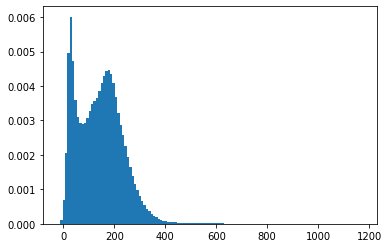

119.169495 ,  73.06181
-24.088926 - 747.9556


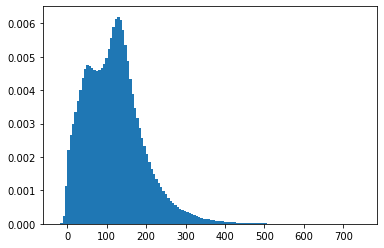

In [38]:
show_dist(image_data + 5 * torch.randn_like(image_data))

4.0338568e-07 ,  0.99999917
-3.0191376 - 6.0890145


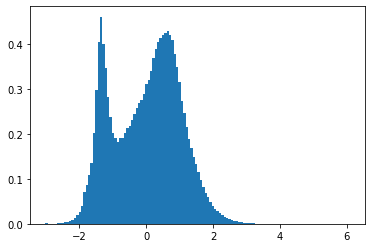

-2.445663e-07 ,  0.99999905
-2.935096 - 5.054449


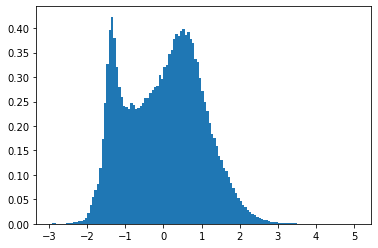

-7.178342e-07 ,  0.9999993
-2.7671025 - 12.087412


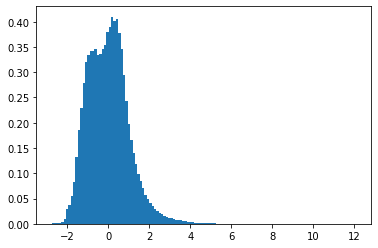

In [36]:
show_dist(torch.stack([d for d,_ in dataset.data], axis=0))

['axial_t2', 'coronal_t2', 'axial_pc']
166.58693 ,  106.8978
0.0 - 1348.0


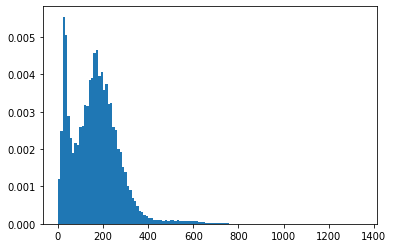

154.11026 ,  96.5073
0.0 - 1370.0


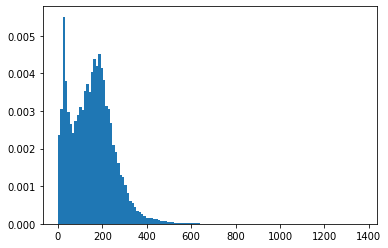

122.9083 ,  79.673096
0.0 - 1157.0


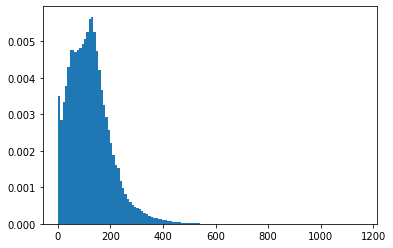

In [40]:
localised_data_path = f'{data_path}/ti_imb/{suffix}_test_fold{fold}.npz'
localised_dataset = MRIDataset(localised_data_path, False, input_size, input_features, transforms=MyRotationTransform(4.0))

show_dist(torch.stack([d for d,_ in localised_dataset.data], axis=0))

In [ ]:
for i in range(0, 5):
    test_sample = image_data[i]
    for chan in range(3):
        display_image(test_sample[chan].numpy(), localised_box_size)
        display_image((test_sample[chan] + 5 * torch.randn_like(test_sample[chan])).numpy(), localised_box_size)

In [1]:
from pytorch_msssim import ssim